In [1]:
# First we'll create an instance of RadarServer to point to the appropriate radar server access URL.

from siphon.radarserver import RadarServer
rs = RadarServer('http://tds-nexrad.scigw.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

In [2]:
# Next, we'll create a new query object to help request the data. Using the chaining methods, let's ask for the latest data at the radar KLVX (Louisville, KY). We see that when the query is represented as a string, it shows the encoded URL.

from datetime import datetime, timedelta
query = rs.query()
query.stations('KLVX').time(datetime.utcnow())

time=2021-06-29T19%3A23%3A10.914490&stn=KLVX

In [3]:
# We can use the RadarServer instance to check our query, to make sure we have required parameters and that we have chosen valid station(s) and variable(s)

rs.validate_query(query)

True

In [4]:
# Make the request, which returns an instance of TDSCatalog; this handles parsing the returned XML information.

catalog = rs.get_catalog(query)


In [5]:
# We can look at the datasets on the catalog to see what data we found by the query. We find one volume in the return, since we asked for the volume nearest to a single time.

catalog.datasets

['KLVX20210629_191726_V06']

In [6]:
# We can grab that datasetthat dataset and call remote_access(), which sets us up to access the data remotely, without downloading the entire file.

data = catalog.datasets[0].remote_access()

In [7]:
# We define some helper functions to make working with the data easier. One takes the raw data and converts it to floating point values with the missing data points appropriately marked. The other helps with converting the polar coordinates (azimuth and range) to Cartesian (x and y).

import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [8]:
# The CDMRemote reader provides an interface that is almost identical to the usual python NetCDF interface. We pull out the variables we need for azimuth and range, as well as the data itself.

sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

In [9]:
# Then convert the raw data to floating point values and the polar coordinates to Cartesian.

ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

In [10]:
# MetPy is a Python package for meteorology (Documentation: http://metpy.readthedocs.org and GitHub: http://github.com/MetPy/MetPy). We import MetPy and use it to get the colortable and value mapping information for the NWS Reflectivity data.

import metpy.plots as mpplots
ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

In [11]:
# Finally, we plot them up using matplotlib and cartopy. We create a helper function for making a map to keep things simpler later.

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_axes([0.02, 0.02, 0.96, 0.96], projection=proj)

    # Add coastlines and states
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    
    return ax

C:\Users\snoda\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


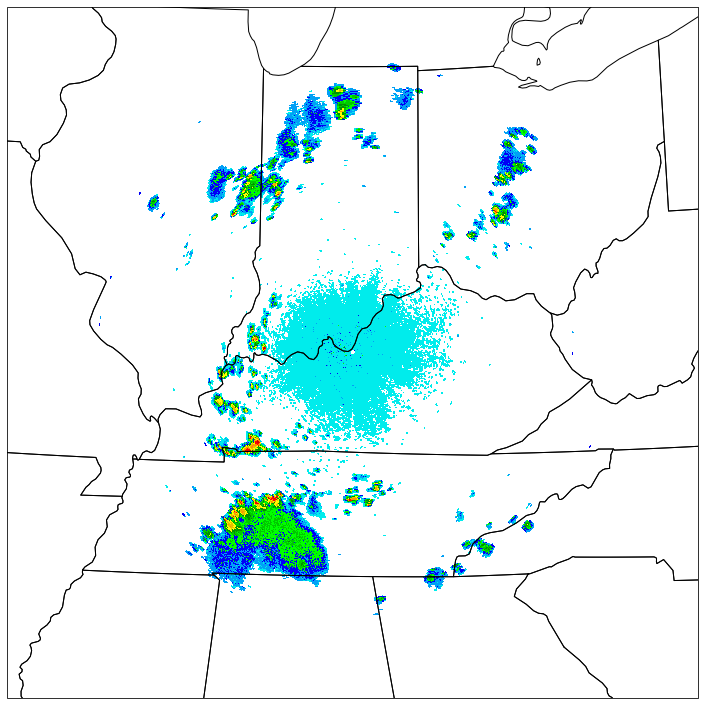

In [12]:
# Use the function to make a new map and plot a colormapped view of the data

fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

In [13]:
# Download a collection of data
# This time we'll make a query based on a longitude, latitude point and using a time range.

query = rs.query()
dt = datetime(2012, 10, 29, 15) # Our specified time
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1))

time_start=2012-10-29T15%3A00%3A00&time_end=2012-10-29T16%3A00%3A00&longitude=-73.687&latitude=41.175

In [14]:
# The specified longitude, latitude are in NY and the TDS helpfully finds the closest station to that point. The time range we request is an hour of data form 29 October 2012; we're looking for data from Hurricane Sandy. We can see that this time we obtained multiple datasets.

cat = rs.get_catalog(query)
cat.datasets

['KOKX20121029_150259_V06.gz', 'KOKX20121029_150854_V06.gz', 'KOKX20121029_151451_V06.gz', 'KOKX20121029_152046_V06.gz', 'KOKX20121029_152639_V06.gz', 'KOKX20121029_153234_V06.gz', 'KOKX20121029_153829_V06.gz', 'KOKX20121029_154422_V06.gz', 'KOKX20121029_155017_V06.gz', 'KOKX20121029_155612_V06.gz']

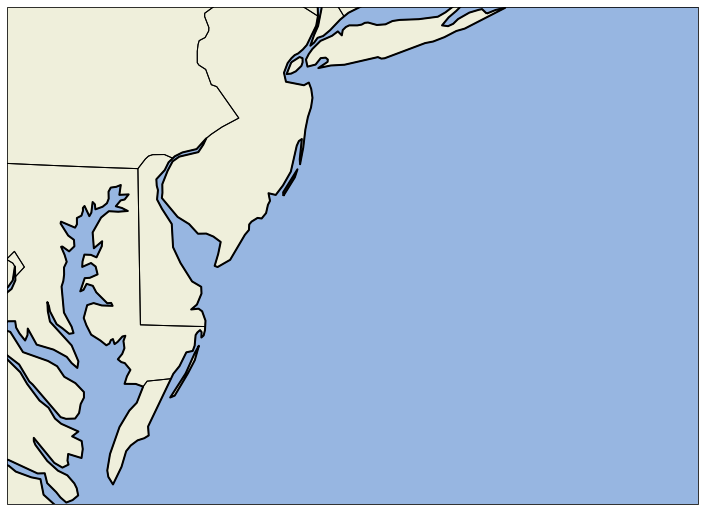

In [15]:
# Grab the first dataset so that we can get the longitude and latitude of the station and make a map for plotting. We'll go ahead and specify some longitude and latitude bounds for the map.

ds = cat.datasets[0]
data = ds.remote_access()
fig = plt.figure(figsize=(10, 7.5))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set limits in lat/lon space
ax.set_extent([-77, -70, 37, 41])

ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))

In [16]:
# Now we can loop over the collection of returned datasets and plot them. As we plot, we collect the returned plot objects so that we can use them to make an animated plot. We also add a timestamp for each plot.

meshes = []
for ds_name in cat.datasets:
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    data = cat.datasets[ds_name].remote_access()

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.7, 0.02, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

In [17]:
# Using matplotlib, we can take a collection of Artists that have been plotted and turn them into an animation. Using the FFMpeg utility, this animation can be converted to HTML5 video viewable in the notebook.

# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)